In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

molecules = (molecules[:ind], molecules[ind:])


ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Model 

In [3]:
filepath = "../models/" + "TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 351)               123552    
_________________________________________________________________
dense_1 (Dense)              (None, 601)               211552    
_________________________________________________________________
dense_2 (Dense)              (None, 501)               301602    
_________________________________________________________________
dense_3 (Dense)              (None, 401)               201302    
_________________________________________________________________
dense_4 (Dense)              (None, 351)               141102    
Total params: 979,110
Trainable params: 979,110
Non-trainable params: 0
_________________________________________________________________


# Guesses 

In [15]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch

p_nn = model.predict(s_test)
p_batch = make_matrix_batch(p_nn, dim=dim, is_triu=True).astype("float64")

In [17]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch, extract_triu_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from pyscf.scf import hf

#s_raw = make_matrix_batch(dataset.inverse_input_transform(dataset.testing[0]), dim, False)

#p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, s_raw)))).astype("float64")
#p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip  (p_batch, s_raw)))).astype("float64")
p_1e = np.array([
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_sap = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

# Iterations 

In [18]:
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer

iterations = []

print("nn")
iterations.append(measure_iterations(mf_initializer, p_batch, molecules[1]))
#print("mcw1")
#iterations.append(measure_iterations(mf_initializer, p_mcw1, molecules[1]))
#print("mcw5")
#iterations.append(measure_iterations(mf_initializer, p_mcw5, molecules[1]))
print("h_core")
iterations.append(measure_iterations(mf_initializer, p_1e, molecules[1]))
print("sap")
iterations.append(measure_iterations(mf_initializer, p_sap, molecules[1]))
print("gwh")
iterations.append(measure_iterations(mf_initializer, p_gwh, molecules[1]))

iterations = np.array(iterations).T
iterations.shape

nn
[ ] 2018-10-02 16:16:45: Iteration calculation: 0
[ ] 2018-10-02 16:16:45: Iteration calculation: 1
[ ] 2018-10-02 16:16:45: Iteration calculation: 2
[ ] 2018-10-02 16:16:46: Iteration calculation: 3
[ ] 2018-10-02 16:16:46: Iteration calculation: 4
[ ] 2018-10-02 16:16:46: Iteration calculation: 5
[ ] 2018-10-02 16:16:46: Iteration calculation: 6
[ ] 2018-10-02 16:16:47: Iteration calculation: 7
[ ] 2018-10-02 16:16:47: Iteration calculation: 8
[ ] 2018-10-02 16:16:47: Iteration calculation: 9
[ ] 2018-10-02 16:16:48: Iteration calculation: 10
[ ] 2018-10-02 16:16:48: Iteration calculation: 11
[ ] 2018-10-02 16:16:48: Iteration calculation: 12
[ ] 2018-10-02 16:16:49: Iteration calculation: 13
[ ] 2018-10-02 16:16:49: Iteration calculation: 14
[ ] 2018-10-02 16:16:49: Iteration calculation: 15
[ ] 2018-10-02 16:16:50: Iteration calculation: 16
[ ] 2018-10-02 16:16:50: Iteration calculation: 17
[ ] 2018-10-02 16:16:50: Iteration calculation: 18
[ ] 2018-10-02 16:16:51: Iteration cal

[ ] 2018-10-02 16:17:30: Iteration calculation: 161
[ ] 2018-10-02 16:17:30: Iteration calculation: 162
[ ] 2018-10-02 16:17:30: Iteration calculation: 163
[ ] 2018-10-02 16:17:31: Iteration calculation: 164
[ ] 2018-10-02 16:17:31: Iteration calculation: 165
[ ] 2018-10-02 16:17:31: Iteration calculation: 166
[ ] 2018-10-02 16:17:31: Iteration calculation: 167
[ ] 2018-10-02 16:17:32: Iteration calculation: 168
[ ] 2018-10-02 16:17:32: Iteration calculation: 169
[ ] 2018-10-02 16:17:32: Iteration calculation: 170
[ ] 2018-10-02 16:17:32: Iteration calculation: 171
[ ] 2018-10-02 16:17:33: Iteration calculation: 172
[ ] 2018-10-02 16:17:33: Iteration calculation: 173
[ ] 2018-10-02 16:17:33: Iteration calculation: 174
[ ] 2018-10-02 16:17:33: Iteration calculation: 175
[ ] 2018-10-02 16:17:34: Iteration calculation: 176
[ ] 2018-10-02 16:17:34: Iteration calculation: 177
[ ] 2018-10-02 16:17:34: Iteration calculation: 178
[ ] 2018-10-02 16:17:34: Iteration calculation: 179
[ ] 2018-10-

[ ] 2018-10-02 16:18:24: Iteration calculation: 120
[ ] 2018-10-02 16:18:24: Iteration calculation: 121
[ ] 2018-10-02 16:18:25: Iteration calculation: 122
[ ] 2018-10-02 16:18:25: Iteration calculation: 123
[ ] 2018-10-02 16:18:26: Iteration calculation: 124
[ ] 2018-10-02 16:18:26: Iteration calculation: 125
[ ] 2018-10-02 16:18:26: Iteration calculation: 126
[ ] 2018-10-02 16:18:27: Iteration calculation: 127
[ ] 2018-10-02 16:18:27: Iteration calculation: 128
[ ] 2018-10-02 16:18:27: Iteration calculation: 129
[ ] 2018-10-02 16:18:28: Iteration calculation: 130
[ ] 2018-10-02 16:18:28: Iteration calculation: 131
[ ] 2018-10-02 16:18:29: Iteration calculation: 132
[ ] 2018-10-02 16:18:29: Iteration calculation: 133
[ ] 2018-10-02 16:18:29: Iteration calculation: 134
[ ] 2018-10-02 16:18:30: Iteration calculation: 135
[ ] 2018-10-02 16:18:30: Iteration calculation: 136
[ ] 2018-10-02 16:18:30: Iteration calculation: 137
[ ] 2018-10-02 16:18:31: Iteration calculation: 138
[ ] 2018-10-

[ ] 2018-10-02 16:19:22: Iteration calculation: 79
[ ] 2018-10-02 16:19:22: Iteration calculation: 80
[ ] 2018-10-02 16:19:23: Iteration calculation: 81
[ ] 2018-10-02 16:19:23: Iteration calculation: 82
[ ] 2018-10-02 16:19:23: Iteration calculation: 83
[ ] 2018-10-02 16:19:24: Iteration calculation: 84
[ ] 2018-10-02 16:19:24: Iteration calculation: 85
[ ] 2018-10-02 16:19:24: Iteration calculation: 86
[ ] 2018-10-02 16:19:25: Iteration calculation: 87
[ ] 2018-10-02 16:19:25: Iteration calculation: 88
[ ] 2018-10-02 16:19:25: Iteration calculation: 89
[ ] 2018-10-02 16:19:25: Iteration calculation: 90
[ ] 2018-10-02 16:19:26: Iteration calculation: 91
[ ] 2018-10-02 16:19:26: Iteration calculation: 92
[ ] 2018-10-02 16:19:26: Iteration calculation: 93
[ ] 2018-10-02 16:19:27: Iteration calculation: 94
[ ] 2018-10-02 16:19:27: Iteration calculation: 95
[ ] 2018-10-02 16:19:27: Iteration calculation: 96
[ ] 2018-10-02 16:19:28: Iteration calculation: 97
[ ] 2018-10-02 16:19:28: Iterat

[ ] 2018-10-02 16:20:22: Iteration calculation: 37
[ ] 2018-10-02 16:20:22: Iteration calculation: 38
[ ] 2018-10-02 16:20:23: Iteration calculation: 39
[ ] 2018-10-02 16:20:23: Iteration calculation: 40
[ ] 2018-10-02 16:20:23: Iteration calculation: 41
[ ] 2018-10-02 16:20:24: Iteration calculation: 42
[ ] 2018-10-02 16:20:24: Iteration calculation: 43
[ ] 2018-10-02 16:20:24: Iteration calculation: 44
[ ] 2018-10-02 16:20:25: Iteration calculation: 45
[ ] 2018-10-02 16:20:25: Iteration calculation: 46
[ ] 2018-10-02 16:20:25: Iteration calculation: 47
[ ] 2018-10-02 16:20:26: Iteration calculation: 48
[ ] 2018-10-02 16:20:26: Iteration calculation: 49
[ ] 2018-10-02 16:20:26: Iteration calculation: 50
[ ] 2018-10-02 16:20:27: Iteration calculation: 51
[ ] 2018-10-02 16:20:27: Iteration calculation: 52
[ ] 2018-10-02 16:20:27: Iteration calculation: 53
[ ] 2018-10-02 16:20:28: Iteration calculation: 54
[ ] 2018-10-02 16:20:28: Iteration calculation: 55
[ ] 2018-10-02 16:20:28: Iterat

[ ] 2018-10-02 16:21:20: Iteration calculation: 196
[ ] 2018-10-02 16:21:20: Iteration calculation: 197
[ ] 2018-10-02 16:21:21: Iteration calculation: 198
[ ] 2018-10-02 16:21:21: Iteration calculation: 199
[ ] 2018-10-02 16:21:22: Iteration calculation: 200


(201, 4)

# Plot 

In [20]:
labels = ["NN", "H_Core", "SAD", "GWH"]

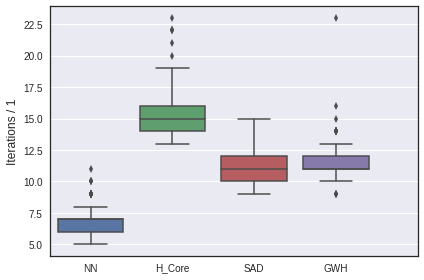

In [25]:
from pandas import DataFrame
from seaborn import boxplot

#frame = DataFrame([[iterations[:,i] for i in range(len(labels))]], columns=labels)
frame = DataFrame(iterations, columns=labels)

boxplot(data=iterations)

plt.xticks(np.arange(5), labels)
plt.ylabel("Iterations / 1")
plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/IterationsBoxPlot.pdf")
plt.show()